# Simple CNN

### Imports

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [375]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from skimage.segmentation import mark_boundaries
from skimage import exposure
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import pickle

from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm

In [101]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape):
        super(SimpleCNN, self).__init__()
        
        patch_size, _, channels = input_shape

        self.conv1 = nn.Conv2d(channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #W_out = (W_in - F + 2P)/S + 1
        self.size_after_pool = ((patch_size-4)//2 - 4)//2
        self.fc1 = nn.Linear(16 * self.size_after_pool * self.size_after_pool, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * self.size_after_pool * self.size_after_pool)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Parameters

In [17]:
medical_data = '/pio/lscratch/1/i279076/Medical/medical.h5'
batch_size = 1024
num_workers = 4
lr = 0.001
log_interval = 50
epochs = 2

### Data loader

In [18]:
import h5py
import random

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler, SequentialSampler, SubsetRandomSampler

In [168]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=32, normalization=None):
        self.original_images = images
        
        self.images = normalization(images) if normalization else images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        patch = torch.from_numpy(patch).float()
        
        return (patch, label)
    
class MedicalSampler(Sampler):
    def __init__(self, positive_indices, negative_indices, num_samples):
        self.num_samples = num_samples
        self.positive = positive_indices
        self.negative = negative_indices

    def __iter__(self):
        self.indices = []
        return self
    
    def __next__(self):
        if len(self.indices) >= self.num_samples:
            raise StopIteration
            
        index = random.choice(self.positive) if torch.rand(1).item() < 0.5 else random.choice(self.negative)
        self.indices.append(index)
        
        return index

    def __len__(self):
        return self.num_samples

class MedicalLoader:
    def __init__(self, dataset_path, patch_size, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_masks = f['train']['masks'][...]

            self.train_positive_indices = f['train']['patches'][str(patch_size)]['positives'][...]
            self.train_negative_indices = f['train']['patches'][str(patch_size)]['negatives'][...]

            self.test_images = f['test']['images'][...]
            self.test_masks = f['test']['masks'][...]

            self.validation_indices = f['validation']['patches'][str(patch_size)]['indices'][...]

        self.train_dataset = MedicalDataset(self.train_images, self.train_masks, patch_size=patch_size)
        self.test_dataset = MedicalDataset(self.test_images, self.test_masks, patch_size=patch_size)
        
    def set_normalization(self, normalization):
        self.train_dataset.images = normalization(self.train_dataset.original_images)
        self.test_dataset.images = normalization(self.test_dataset.original_images)

    def train_loader(self, slice):
        sampler = MedicalSampler(self.train_positive_indices, self.train_negative_indices, int(len(self.train_dataset) * slice))
        loader = DataLoader(self.train_dataset, sampler=sampler, **self.loader_args)
        return loader

    def validation_loader(self, train=False):
        sampler = SubsetRandomSampler([] if train else self.validation_indices)
        loader = DataLoader(self.train_dataset if train else self.test_dataset, sampler=sampler, **self.loader_args)
        return loader

    def test_loader(self, slice=None):
        sampler = SequentialSampler(self.test_dataset) 
        if slice is not None:
            n = len(self.test_dataset)
            sampler = SubsetRandomSampler(np.random.choice(n, int(n * slice)))
        loader = DataLoader(self.test_dataset, sampler=sampler, **self.loader_args)

        return loader

In [169]:
medical_loader = MedicalLoader(medical_data, 32, 256)

## Normalization

In [170]:
def identity(images):
    return images

def grey_scale(images):
    return images.dot([0.299, 0.587, 0.114])[:, :, :, None]

def middle_channel(images):
    return images[:, :, :, 1][:, :, :, None]

def equalize_hist_middle(images):
    images = images[:, :, :, 1]
    images_eq = np.zeros_like(images, dtype=np.float)
    for i in range(len(images_eq)):
        images_eq[i] = exposure.equalize_hist(images[i])
    return images_eq[:, :, :, None]

def equalize_hist(images):
    images_eq = np.zeros_like(images, dtype=np.float)
    for i in range(len(images_eq)):
        for d in range(3):
            images_eq[i, :, :, d] = exposure.equalize_hist(images[i, :, :, d])
    return images_eq

In [171]:
normalization = equalize_hist
input_shape = (32, 32, 3)

In [172]:
medical_loader.set_normalization(normalization)

In [174]:
train_loader = medical_loader.train_loader(0.01)
test_loader = medical_loader.test_loader(0.0005)

#### Training

In [323]:
model = SimpleCNN(input_shape).cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []

In [328]:
for epoch in tnrange(10):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader, leave=False, desc=f'epoch no. {epoch + 1}'), 1):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    running_loss /= len(train_loader)
    print('[{}, {:5d}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss))
    losses.append(running_loss)

print('Finished Training')

[1,  5505] loss: 0.076


[2,  5505] loss: 0.075


[3,  5505] loss: 0.074


[4,  5505] loss: 0.074


[5,  5505] loss: 0.073


[6,  5505] loss: 0.072


[7,  5505] loss: 0.072


[8,  5505] loss: 0.070


[9,  5505] loss: 0.070


[10,  5505] loss: 0.069
Finished Training


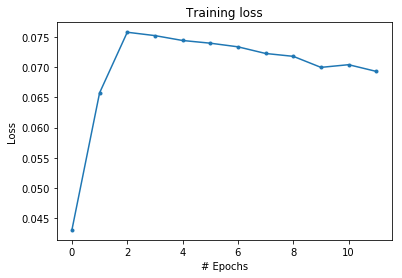

In [329]:
plt.plot(losses, '.-')

plt.title('Training loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')

plt.show()

In [344]:
torch.save(model.state_dict(), '.cache/simplecnn_{:.3f}'.format(losses[-1]))

In [330]:
predictions, targets = [], []

with torch.no_grad():
    for (images, labels) in tqdm(test_loader):
        images, labels = images.cuda(), labels.cuda()
        
        output = model(images.float())
        predictions.extend(output.squeeze().tolist())
        targets.extend(labels.cpu().tolist())

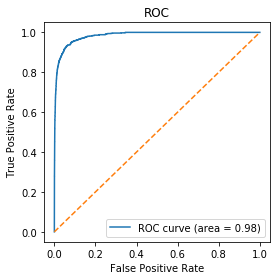

In [331]:
plt.figure(figsize=(4, 4))

fpr, tpr, thresholds = roc_curve(targets, predictions)

area = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(area))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [178]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [192]:
optimal_idx = len(tpr[fpr <= 0.01])
optimal_threshold = thresholds[optimal_idx]

In [333]:
class ImageDataset(Dataset):
    def __init__(self, image, mask, patch_size=22, normalization=None):
        image_size, _, _ = image.shape
        size = image_size + patch_size - 1
        offset = patch_size // 2
        
        extended_image = np.zeros((size, size, 3))
        extended_image[offset: offset + image_size, offset: offset + image_size] = image
        
        if normalization:
            extended_image = normalization(extended_image[None])[0]
        
        extended_mask = np.zeros((size, size, 1))
        extended_mask[offset: offset + image_size, offset: offset + image_size] = mask
        
        self.image = extended_image
        self.mask = extended_mask
        
        self.patch_size = patch_size
        
        self.image_size, _, _ = self.image.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.patches_per_image
    
    def __getitem__(self, idx):                
        y = idx // self.patches_per_side
        x = idx % self.patches_per_side
        
        patch = self.image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = self.mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        return (patch, label)

In [334]:
indices = [i for i in range(len(medical_loader.test_masks)) if medical_loader.test_masks[i].sum() > 0]

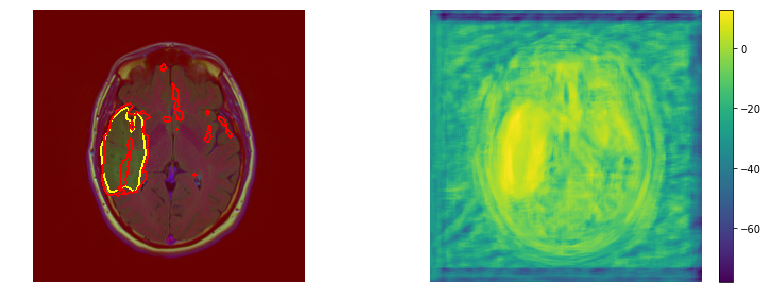

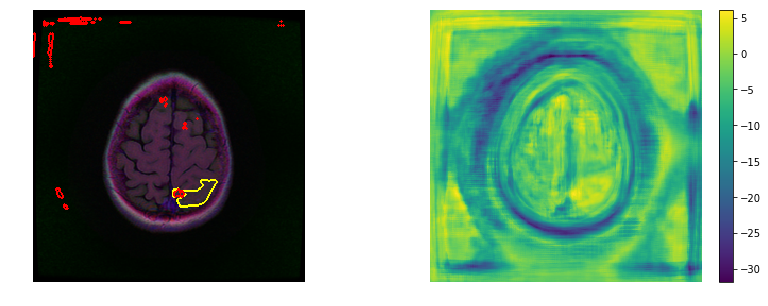

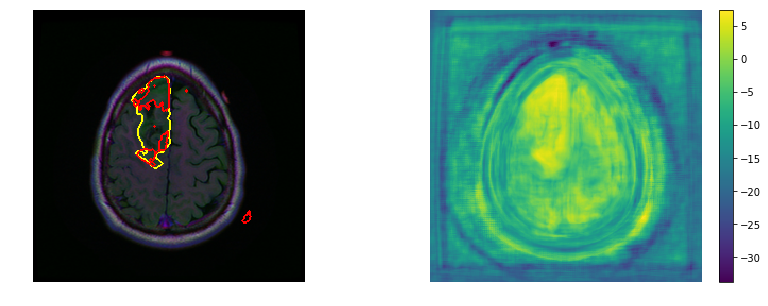

In [338]:
for idx in np.random.choice(indices, 3, replace=False):
    image = medical_loader.test_images[idx]
    mask = medical_loader.test_masks[idx]
    
    image_loader = DataLoader(ImageDataset(image, mask, 32, normalization), batch_size=128, num_workers=8)
    
    predicted_mask = []

    with torch.no_grad():
        for (images, labels) in image_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images.float())
            
            predicted = outputs.squeeze().cpu()
            predicted_mask.extend(predicted.tolist())
            
    predicted_mask = np.array(predicted_mask).reshape(256, 256)
    recon_mask = (predicted_mask > optimal_threshold) * 1.
    
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    masked_image = mark_boundaries(image, mask.squeeze(), mode='thick')
    plt.imshow(mark_boundaries(masked_image, recon_mask, color=(1, 0, 0), mode='thick'))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(predicted_mask)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [345]:
with h5py.File('/pio/lscratch/1/i279076/Medical/medical_v2.h5', 'r') as f:
    medical_images = f['test/images'][...]
    medical_masks = f['test/masks'][...]
    medical_patients = f['test/patients'][...]
    
#     medical_images = np.hstack([f['test/images'], f['train/images']])[...]
#     mdeical_masks = np.hstack([f['test/masks'], f['train/masks']])[...]
#     medical_patients = np.hstack([f['test/patients'], f['train/patients']])[...]

In [349]:
processed_images = []

# for patient in tqdm(np.random.choice(np.unique(medical_patients), 10, replace=False)):
for patient in tqdm(np.unique(medical_patients)):
    patient_images, patient_masks = medical_images[medical_patients == patient], medical_masks[medical_patients == patient]
    
    for i in tnrange(len(patient_masks), leave=False, desc=f'patient no. {patient}'):
        image, mask = patient_images[i], patient_masks[i]
        image_loader = DataLoader(ImageDataset(image, mask, 32, normalization), batch_size=512, num_workers=8)
        predicted_mask = []

        with torch.no_grad():
            for (data, labels) in image_loader:
                data, labels = data.cuda(), labels.cuda()

                outputs = model(data.float())
                
                predicted = outputs.squeeze().cpu()
                predicted_mask.extend(predicted.tolist())

        predicted_mask = np.array(predicted_mask).reshape(256, 256)
        mask = mask.squeeze()

        processed_images.append((image, mask, predicted_mask, patient))

In [376]:
with open('.cache/patients_simplecnn', 'wb') as fp:
    pickle.dump(processed_images, fp)

In [350]:
filtered_images = [(image, mask, recon_mask) for image, mask, recon_mask, _ in processed_images if mask.sum() > 0]

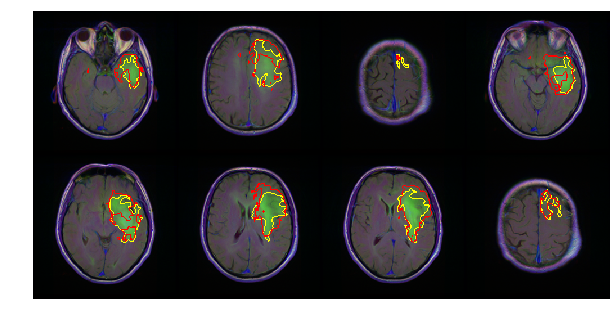

In [351]:
plt.figure(figsize=(8, 4))

for i, (image, mask, predicted_mask) in enumerate(filtered_images[:8], 1):    
    plt.subplot(2, 4, i)
    
    recon_mask = (predicted_mask > optimal_threshold) * 1.
    
    masked_image = mark_boundaries(image, mask, mode='thick')
    plt.imshow(mark_boundaries(masked_image, recon_mask, color=(1, 0, 0), mode='thick'))
    plt.axis('off')

plt.subplots_adjust(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
plt.show()

In [371]:
cm = np.zeros((2, 2))

for image, mask, predicted_mask, _ in processed_images:
    recon_mask = (predicted_mask > optimal_threshold).astype(int)
    
    cm[min(mask.sum(), 1), min(recon_mask.sum(), 1)] += 1

[[254. 490.]
 [  3. 415.]]


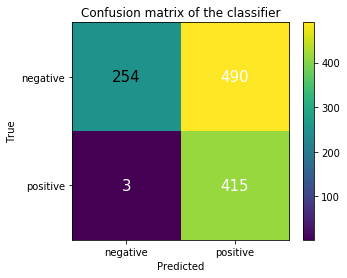

In [372]:
labels = ['negative', 'positive']
print(cm)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()

for x, y, amount, c in zip([0, 1, 0, 1], [0, 0, 1, 1], cm.flatten(), ['black', 'w', 'w', 'w']):
    plt.text(x, y, int(amount), color=c, fontsize=15, ha='center', va='center')

plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [373]:
from collections import Counter

common_stats = Counter()
sum_stats = Counter()

for image, mask, predicted_mask, patient in processed_images:
    recon_mask = (predicted_mask > optimal_threshold).astype(int)
    common_mask = np.logical_and(mask, recon_mask) * 1.0
    
    common_stats[patient] += common_mask.sum()
    sum_stats[patient] += mask.sum() + recon_mask.sum()

dsc_stats = []
for patient in sum_stats.keys():
    dsc = 2 * common_stats[patient] / sum_stats[patient]
    dsc_stats.append(dsc)

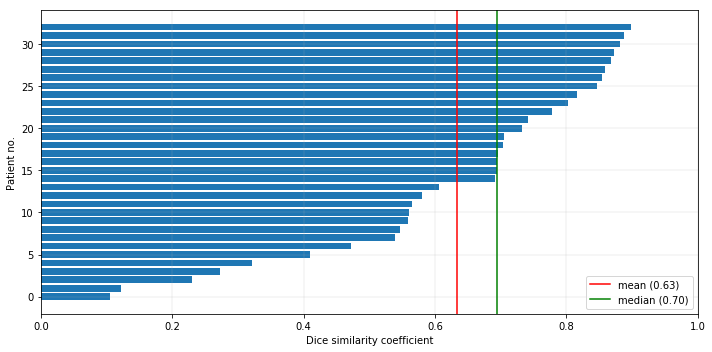

In [381]:
plt.figure(figsize=(10, 5))

plt.barh(range(len(dsc_stats)), sorted(dsc_stats), height=.8)
plt.grid(True, lw=0.2)

plt.axvline(np.mean(dsc_stats), c='r', label='mean ({:.2f})'.format(np.mean(dsc_stats)))
plt.axvline(np.median(dsc_stats), c='g', label='median ({:.2f})'.format(np.median(dsc_stats)))

plt.xlim(0, 1.)
plt.xlabel('Dice similarity coefficient')
plt.ylabel('Patient no.')
# plt.title()
plt.legend()

plt.tight_layout()
plt.show()